# 11 Word2Vec Implemented in Gensim

## Learn word vectors from F.R.I.E.N.D.S.

Originally developed as a collection of python scripts implementing latent semantic methods, Gensim has developed into an world-class NLP resource. Now, it is a leading and a state-of-the-art package for processing texts, working with word vector models (such as Word2Vec, FastText etc) and for building topic models.

**Therefore, we do not need to implement word2vec from scratch.**


## Agenda

1. Prepare Corpus
2. Text Cleaning
3. Word2Vec Training
4. Explore the learned word vectors

In [2]:
import re  
import pandas as pd 
from collections import defaultdict  # For word frequency
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

### Part 1: Prepare Corpus

**Corpus**:

Here, we will look at the transcripts from F.R.I.E.N.D.S. It is because I love watching Friends and also the data is already prepared by someone (credit: [Shilpi Bhattacharyya](https://towardsdatascience.com/now-we-have-tv-sitcom-f-r-i-e-n-d-s-dataset-created-from-web-transcripts-908af7777977)
).

<img src="imgs\friends.jpg" alt="cbow"
	title="cbow pic" width="300" height="250" />
    

This dataset contains the speaker, location, scene, season number and text i.e. script lines covering the 10 seasons. Here, we keep only one column: **Text**.


In [4]:
df = pd.read_csv('data//friends_dataset.csv', index_col=None)
df.shape

(93335, 6)

In [3]:
df.head(3)

,Unnamed: 0,Location,Scene,Season,Speaker,Text
0,0,Chandler and Joey's,Joey is repacking the furniture into boxes to...,4,Joey,What?
1,1,Monica and Rachel's,"the next morning, Monica is getting the door,",1,Monica,"Oh, you got the whole night, huh?"
2,2,Mike's apartment,His phone rings and he picks up,9,Chandler,"Phoebe is going to say ""yes""? That's, that's g..."


In [4]:
df = df[['Text']]

### Part 2: Text Clean

For each line of dialogue, we will remove stop-words, non-alphbetic characters and conver all of them to lower-case.

#### Regarding Stop words:
https://kavita-ganesan.com/what-are-stop-words/#.XlZv5pMzbYU

https://www.quora.com/Is-it-compulsory-to-remove-stop-words-with-word2vec

In [5]:
brief_cleaning = lambda x: re.sub("[^A-Za-z']+", ' ', str(x)).lower()

In [6]:
df["clean"] = df.Text.apply(brief_cleaning)

In [7]:
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

In [8]:
def cleaning(doc):
    # very simple tokenizer
    txt =doc.strip().split()
    txt = [word for word in txt if word not in stop_words]
    # remove the short sentence, since the context information is not enough
    if len(txt) > 2:
        return ' '.join(txt)

remove the short line

In [9]:
txt = [cleaning(doc) for doc in df.clean.values]

In [10]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(27047, 1)

In [11]:
df_clean.head(5)

,clean
1,oh got whole night huh
2,phoebe going say yes that's that's great
5,look like something girlfriend paleontologist ...
9,rachel joey rachel joey
11,ring cave yeah


#### Build Bigrams:
We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences. https://radimrehurek.com/gensim/models/phrases.html

The main reason we do this is to catch words like "rachel_green" or "break_up" ! We will regard those detected phrase as a single word, which will improve the quality of the learned embeddings. 

In [12]:
from gensim.models.phrases import Phrases, Phraser

In [13]:
# take a list of list of words as input
sent = [row.split() for row in df_clean['clean']]

In [14]:
phrases = Phrases(sent, min_count=10, progress_per=10000)

INFO - 22:18:34: collecting all words and their counts
INFO - 22:18:34: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 22:18:34: PROGRESS: at sentence #10000, processed 70067 words and 50342 word types
INFO - 22:18:34: PROGRESS: at sentence #20000, processed 141347 words and 88437 word types
INFO - 22:18:34: collected 111960 word types from a corpus of 191459 words (unigram + bigrams) and 27047 sentences
INFO - 22:18:34: using 111960 counts as vocab in Phrases<0 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>


In [15]:
bigram = Phraser(phrases)

INFO - 22:18:35: source_vocab length 111960
INFO - 22:18:36: Phraser built with 137 phrasegrams


In [16]:
sentences = bigram[sent]

In [17]:
# check the extracted bigram. Take phoebe_buffay as an example
for idx in range(len(sentences)):
    if "phoebe_buffay" in sentences[idx]:
        print("before bigram extracting")
        print(sent[idx])
        print("after bigram extracting")
        print(sentences[idx])
        break

before bigram extracting
['yeah', "i'm", 'phoebe', 'buffay', 'hannigan', 'banana', 'hammock']
after bigram extracting
['yeah', "i'm", 'phoebe_buffay', 'hannigan', 'banana', 'hammock']


#### Most Frequent Words
check the effectivenss of the above text preprocessing

In [18]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

12086

In [19]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'know', 'okay', 'well', 'yeah', 'right', 'like', 'gonna', 'hey', 'get']

### Part 3: Word2Vec Training

We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

Word2vec's training in gensim can be generally decomposed into three steps: 

1. Word2Vec():

>In this first step, I set up the hyper-parameters of the model one-by-one. The corpus will not be provided at this step.


2. .build_vocab():

>Here it builds the vocabulary from a sequence of sentences and thus initialized the model.
With the loggings, the effect of the pre-defined hyper-parameters in step 1 such as min_count and sample on the word corpus can be monitored. The whole process will be displayed here for a double-check of these hyperparmaters' influence.


3. .train():

>Finally, the model is trained and word vectors are updated. The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [20]:
# gensim support multi-core training
import multiprocessing
cores = multiprocessing.cpu_count()

In [21]:
from gensim.models import Word2Vec

#### Doc for hyperpameters in word2vec:

* min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)

* window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)

* size = int - Dimensionality of the feature vectors. - (50, 300)

* sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)

* alpha = float - The initial learning rate - (0.01, 0.05)

* min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00

* negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20). Here, in slides, we mentioned that to overcome the heavy softmax layer computation issue, negative sampling is one of the two approaches.

* workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [45]:
w2v_model = Word2Vec(min_count=10,
                     window=3,
                     size=55,
                     sample=6e-5, 
                     alpha=0.05, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

WARNING - 22:21:44: consider setting layer size to a multiple of 4 for greater performance


#### Building the Vocabulary:

Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them) based on the hyperparameters set in the previous step.

In [46]:
w2v_model.build_vocab(sentences, progress_per=10000)

INFO - 22:21:46: collecting all words and their counts
INFO - 22:21:46: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 22:21:46: PROGRESS: at sentence #10000, processed 68223 words, keeping 7423 word types
INFO - 22:21:47: PROGRESS: at sentence #20000, processed 137813 words, keeping 10533 word types
INFO - 22:21:47: collected 12086 word types from a corpus of 186679 raw words and 27047 sentences
INFO - 22:21:47: Loading a fresh vocabulary
INFO - 22:21:47: effective_min_count=10 retains 1990 unique words (16% of original 12086, drops 10096)
INFO - 22:21:47: effective_min_count=10 leaves 163795 word corpus (87% of original 186679, drops 22884)
INFO - 22:21:47: deleting the raw counts dictionary of 12086 items
INFO - 22:21:47: sample=6e-05 downsamples 959 most-common words
INFO - 22:21:47: downsampling leaves estimated 55919 word corpus (34.1% of prior 163795)
INFO - 22:21:47: estimated required memory for 1990 words and 55 dimensions: 1870600 bytes
INFO - 22:21

#### Training of the model:

Doc for hyperparameters:

* total_examples = int - Count of sentences;

* epochs = int - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [47]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=40, report_delay=1)

INFO - 22:21:53: training model with 3 workers on 1990 vocabulary and 55 features, using sg=0 hs=0 sample=6e-05 negative=20 window=3
INFO - 22:21:54: EPOCH 1 - PROGRESS: at 80.43% examples, 43411 words/s, in_qsize 0, out_qsize 0
INFO - 22:21:55: worker thread finished; awaiting finish of 2 more threads
INFO - 22:21:55: worker thread finished; awaiting finish of 1 more threads
INFO - 22:21:55: worker thread finished; awaiting finish of 0 more threads
INFO - 22:21:55: EPOCH - 1 : training on 186679 raw words (55957 effective words) took 1.4s, 38667 effective words/s
INFO - 22:21:56: EPOCH 2 - PROGRESS: at 64.42% examples, 35835 words/s, in_qsize 0, out_qsize 0
INFO - 22:21:57: worker thread finished; awaiting finish of 2 more threads
INFO - 22:21:57: worker thread finished; awaiting finish of 1 more threads
INFO - 22:21:57: worker thread finished; awaiting finish of 0 more threads
INFO - 22:21:57: EPOCH - 2 : training on 186679 raw words (55977 effective words) took 2.0s, 28374 effective

INFO - 22:22:27: worker thread finished; awaiting finish of 1 more threads
INFO - 22:22:27: worker thread finished; awaiting finish of 0 more threads
INFO - 22:22:27: EPOCH - 18 : training on 186679 raw words (55954 effective words) took 2.0s, 27319 effective words/s
INFO - 22:22:28: EPOCH 19 - PROGRESS: at 37.84% examples, 20995 words/s, in_qsize 0, out_qsize 0
INFO - 22:22:29: EPOCH 19 - PROGRESS: at 96.35% examples, 26066 words/s, in_qsize 0, out_qsize 0
INFO - 22:22:29: worker thread finished; awaiting finish of 2 more threads
INFO - 22:22:29: worker thread finished; awaiting finish of 1 more threads
INFO - 22:22:29: worker thread finished; awaiting finish of 0 more threads
INFO - 22:22:29: EPOCH - 19 : training on 186679 raw words (55793 effective words) took 2.1s, 25977 effective words/s
INFO - 22:22:30: EPOCH 20 - PROGRESS: at 53.69% examples, 27989 words/s, in_qsize 0, out_qsize 0
INFO - 22:22:31: EPOCH 20 - PROGRESS: at 96.35% examples, 25376 words/s, in_qsize 4, out_qsize 0
I

INFO - 22:22:59: EPOCH - 35 : training on 186679 raw words (56045 effective words) took 1.5s, 36733 effective words/s
INFO - 22:23:00: EPOCH 36 - PROGRESS: at 75.13% examples, 39136 words/s, in_qsize 0, out_qsize 0
INFO - 22:23:00: worker thread finished; awaiting finish of 2 more threads
INFO - 22:23:00: worker thread finished; awaiting finish of 1 more threads
INFO - 22:23:00: worker thread finished; awaiting finish of 0 more threads
INFO - 22:23:00: EPOCH - 36 : training on 186679 raw words (56179 effective words) took 1.6s, 35840 effective words/s
INFO - 22:23:02: EPOCH 37 - PROGRESS: at 43.02% examples, 23036 words/s, in_qsize 0, out_qsize 0
INFO - 22:23:02: worker thread finished; awaiting finish of 2 more threads
INFO - 22:23:02: worker thread finished; awaiting finish of 1 more threads
INFO - 22:23:02: worker thread finished; awaiting finish of 0 more threads
INFO - 22:23:02: EPOCH - 37 : training on 186679 raw words (55886 effective words) took 1.9s, 29804 effective words/s
IN

(2237224, 7467160)

we can save the model and load it again

In [48]:
w2v_model.save('tmp_model')
#new_model = gensim.models.Word2Vec.load('tmp_model')

INFO - 22:23:10: saving Word2Vec object under tmp_model, separately None
INFO - 22:23:10: not storing attribute vectors_norm
INFO - 22:23:10: not storing attribute cum_table
INFO - 22:23:10: saved tmp_model


As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:

In [49]:
w2v_model.init_sims(replace=True)

INFO - 22:23:12: precomputing L2-norms of word weight vectors


### Part 4: Explore the learned word2vec model

Gensim also provides lots of functions to manipulate word vectors. Let us check some of them

We can check what we will get for the main characters. Make fun with these learned word vectors. 

#### Given a word, find its most Similar

#####  Look at similar words for joey

This is one of the main characters in Friends.

<img src="imgs\joey.jpeg" alt="joey"
	title="cbow pic" width="300" height="250" />

In [50]:
w2v_model.wv.most_similar(positive=["joey"])

[('chandler', 0.6380542516708374),
 ('doin', 0.6036429405212402),
 ('chan', 0.5946396589279175),
 ('janine', 0.5850124359130859),
 ('favor', 0.5687410831451416),
 ('dina', 0.5581873059272766),
 ('j', 0.5555078983306885),
 ('trade', 0.5504496693611145),
 ('please', 0.5444128513336182),
 ('talkin', 0.5405898690223694)]

the score is the cosine value between two vectors.

Look like the model makes sense, since chandler and joey are best roommates.

And the second similar words "doin" is in his famous line: ``How You Doin``

<img src="imgs\joey_chan.jpeg" alt="joeychan"
	title="cbow pic" width="300" height="250" />

Then, how about the bigram "joey tribbiani". It is the full name.

In [51]:
w2v_model.wv.most_similar(positive=["joey_tribbiani"])

[('moves', 0.6831839084625244),
 ('scene', 0.6238728165626526),
 ('days_lives', 0.6180239915847778),
 ('dr_drake', 0.6157978773117065),
 ('valentine_day', 0.6085768342018127),
 ('stars', 0.6012861132621765),
 ('nice_meet', 0.5954543352127075),
 ("ross's", 0.5780478715896606),
 ('italian', 0.5721103549003601),
 ('soap_opera', 0.5681972503662109)]

This model returns more words related to Joey's job: actor. 

<img src="imgs\dlife.jpeg" alt="joeychan"
	title="cbow pic" width="300" height="250" />

#### Given a list of words, find the word that does not belong to the list.

How about friendship among these three girls?

In [53]:
w2v_model.wv.doesnt_match(['monica', 'rachel', 'phoebe'])

'monica'

#### Analogy difference:

Which word is to woman as ross is to man?

In [55]:
w2v_model.wv.most_similar(positive=["woman", "ross"], negative=["man"], topn=3)

[('knowing', 0.5938038229942322),
 ('happen', 0.5827463269233704),
 ('rachel', 0.5677865743637085)]

Rachel is in the top3 list!!! Seems the result is not bad.

<img src="imgs\love.jpeg" alt="joeychan"
	title="cbow pic" width="300" height="250" />

#### How to take word vectors out?

We can also extract vectors from the w2v model and utilize them with other methods. 

In [56]:
vocabs = []
vecs = []
for word in w2v_model.wv.vocab:
    vocabs.append(word)
    vecs.append(w2v_model[word])

/Users/rui/pyenv/bt5153/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


#### Visualize these word embeddings

We can reduce the embeddings size to 2 by TSNE (non-linear dimensionality reduction method)

In [57]:
from sklearn.manifold import TSNE
sub_vecs = vecs[:100]
sub_vocab = vocabs[:100]
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2000, random_state=23)
new_values = tsne_model.fit_transform(sub_vecs)

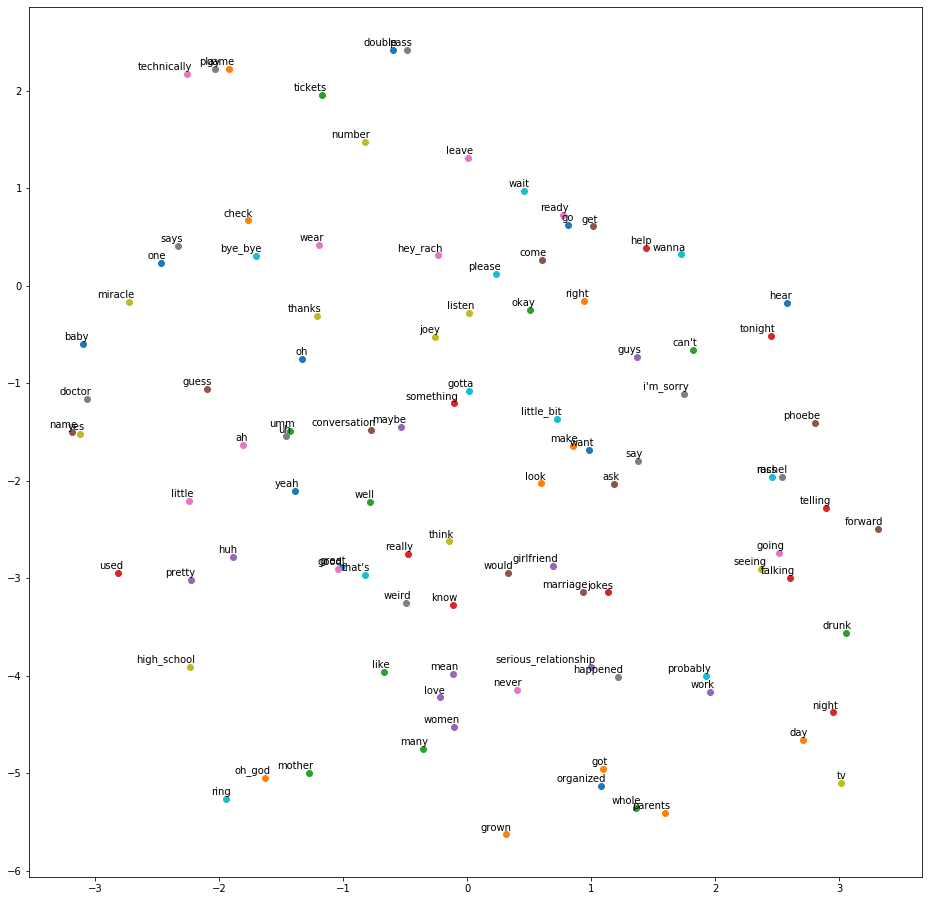

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
        
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(sub_vocab[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
plt.show()

Other Tutorial about gensim:

http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W467ScBjM2x

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/